In [2]:
import sys
sys.path.append('../../../../../../src')
import pandas
import random
import math
from energiapy.components.temporal_scale import TemporalScale
from energiapy.components.resource import Resource, VaryingResource
from energiapy.components.process import Process, ProcessMode, VaryingProcess
from energiapy.components.location import Location
from energiapy.components.transport import Transport
from energiapy.components.network import Network
from energiapy.components.scenario import Scenario
# from energiapy.model.constraints.demand import constraint_demand2
from energiapy.components.result import Result
from energiapy.model.formulate import formulate, Constraints, Objective
from energiapy.plot import plot_results, plot_scenario, plot_location
from energiapy.model.solve import solve
from pyomo.environ import Param
from energiapy.utils.scale_utils import scale_pyomo_set
import matplotlib.pyplot as plt
from matplotlib import rc


In [3]:
_time_intervals = 7  # Number of time intervals in a planning horizon    (L_chi)
_coms = 1
_exec_scenarios = 48  # Number of execution scenarios                     (chi)
M = 1e3  # Big M

loc6_varying_factor = pandas.DataFrame(data={'com1_process': [1]*24 + [0]*24})

# Define temporal scales
scales = TemporalScale(discretization_list=[1, _exec_scenarios, _time_intervals])

In [4]:
# ======================================================================================================================
# Declare resources/commodities
# ======================================================================================================================
com1_pur = Resource(name='com1_pur', cons_max=75, block={'imp': 1, 'urg': 1}, price=0.00, label='Commodity 1 consumed from outside the system')

com1_in = Resource(name='com1_in', label='Commodity 1 received')
com1_out = Resource(name='com1_out', label='Commodity 1 to be sent out')

com1_loc1_out = Resource(name='com1_loc1_out', label='Commodity 1 sent out from location 1')
com1_loc2_out = Resource(name='com1_loc2_out', label='Commodity 1 sent out from location 2')
com1_loc3_out = Resource(name='com1_loc3_out', label='Commodity 1 sent out from location 3')
com1_loc4_out = Resource(name='com1_loc4_out', label='Commodity 1 sent out from location 4')
com1_loc5_out = Resource(name='com1_loc5_out', label='Commodity 1 sent out from location 5')
com1_loc6_out = Resource(name='com1_loc6_out', label='Commodity 1 sent out from location 6')
com1_loc7_out = Resource(name='com1_loc7_out', label='Commodity 1 sent out from location 7')

com1_sold = Resource(name='com1_sold', revenue=0.00, demand=True, sell=True, label='Commodity 1 sold to outside the system')

In [5]:
# prod_max = {0:60, 1: 120, 2: 150}
# prod_min = {0:0, 1: 60, 2: 120}
# rate_max = {0:4, 1:2, 2:1}

prod_max = {0:30, 1: 60, 2: 90, 3: 120, 4: 150}
prod_min = {0:0, 1: 30, 2: 60, 3: 90, 4: 120}
rate_max = {0:1.25/2, 1: 1/2, 2: 0.75/2, 3: 0.5/2, 4: 0.25/2}
mode_ramp = {(0,1): 5, (1,2): 5}

In [6]:
# # ======================================================================================================================
# # Declare processes/storage capacities
# # ======================================================================================================================
# 
# com1_procure = Process(name='procure com1', prod_max=75, conversion={com1_pur: -1, com1_in: 1}, capex=0.1, vopex=0.1, prod_min=75, label='Procure com1')
# com1_sell = Process(name='sell com1', prod_max=M, conversion={com1_out: -1, com1_sold: 1}, capex=0.1, vopex=0.1, prod_min=M, label='Sell com1')
# 
# com1_receive_loc1 = Process(name='com1_receive_loc1', prod_max=150, conversion={com1_loc1_out:-1, com1_in:1}, capex=0.1, vopex=0.1, prod_min=150, label='Commodity 1 received from location 1')
# com1_receive_loc2 = Process(name='com1_receive_loc2', prod_max=150, conversion={com1_loc2_out:-1, com1_in:1}, capex=0.1, vopex=0.1, prod_min=150, label='Commodity 1 received from location 2')
# com1_receive_loc3 = Process(name='com1_receive_loc3', prod_max=150, conversion={com1_loc3_out:-1, com1_in:1}, capex=0.1, vopex=0.1, prod_min=150, label='Commodity 1 received from location 3')
# com1_receive_loc4 = Process(name='com1_receive_loc4', prod_max=150, conversion={com1_loc4_out:-1, com1_in:1}, capex=0.1, vopex=0.1, prod_min=150, label='Commodity 1 received from location 4')
# com1_receive_loc5 = Process(name='com1_receive_loc5', prod_max=150, conversion={com1_loc5_out:-1, com1_in:1}, capex=0.1, vopex=0.1, prod_min=150, label='Commodity 1 received from location 5')
# com1_receive_loc6 = Process(name='com1_receive_loc6', prod_max=150, conversion={com1_loc6_out:-1, com1_in:1}, capex=0.1, vopex=0.1, prod_min=150, label='Commodity 1 received from location 6')
# com1_receive_loc7 = Process(name='com1_receive_loc7', prod_max=150, conversion={com1_loc7_out:-1, com1_in:1}, capex=0.1, vopex=0.1, prod_min=150, label='Commodity 1 received from location 7')
# 
# com1_process = Process(name='com1_process', prod_max=prod_max, conversion={0:{com1_in: -1, com1_out: 1}, 1:{com1_in: -1, com1_out: 1}, 2:{com1_in: -1, com1_out: 1}, 3:{com1_in: -1, com1_out: 1}, 4:{com1_in: -1, com1_out: 1}}, capex=0.1, vopex=0.1, prod_min=prod_min, rate_max=rate_max, varying=[VaryingProcess.DETERMINISTIC_CAPACITY], label='Process the commodity through the location')
# 
# com1_store10 = Process(name='com1_store10', prod_max=150, capex=100, vopex=1, store_min=0.01, store_max= 20, prod_min=150, label="Storage capacity of 10 units", storage=com1_in, storage_cost=0.02)
# com1_store20 = Process(name='com1_store20', prod_max=150, capex=200, vopex=2, store_min=0.01,store_max= 40, prod_min=150, label="Storage capacity of 20 units", storage=com1_in, storage_cost=0.02)
# com1_store50 = Process(name='com1_store50', prod_max=150, capex=500, vopex=5, store_min=0.01, store_max= 100, prod_min=150, label="Storage capacity of 50 units", storage=com1_in, storage_cost=0.02)
# 
# com1_loc1_send = Process(name='com1_loc1_send', prod_max=150, conversion={com1_out:-1, com1_loc1_out:1}, capex=0.1, vopex=0.1, prod_min=150, label='Send commodity one from location 1')
# com1_loc2_send = Process(name='com1_loc2_send', prod_max=150, conversion={com1_out:-1, com1_loc2_out:1}, capex=0.1, vopex=0.1, prod_min=150, label='Send commodity one from location 2')
# com1_loc3_send = Process(name='com1_loc3_send', prod_max=150, conversion={com1_out:-1, com1_loc3_out:1}, capex=0.1, vopex=0.1, prod_min=150, label='Send commodity one from location 3')
# com1_loc4_send = Process(name='com1_loc4_send', prod_max=150, conversion={com1_out:-1, com1_loc4_out:1}, capex=0.1, vopex=0.1, prod_min=150, label='Send commodity one from location 4')
# com1_loc5_send = Process(name='com1_loc5_send', prod_max=150, conversion={com1_out:-1, com1_loc5_out:1}, capex=0.1, vopex=0.1, prod_min=150, label='Send commodity one from location 5')
# com1_loc6_send = Process(name='com1_loc6_send', prod_max=150, conversion={com1_out:-1, com1_loc6_out:1}, capex=0.1, vopex=0.1, prod_min=150, label='Send commodity one from location 6')
# com1_loc7_send = Process(name='com1_loc7_send', prod_max=150, conversion={com1_out:-1, com1_loc7_out:1}, capex=0.1, vopex=0.1, prod_min=150, label='Send commodity one from location 7')

In [7]:
# ======================================================================================================================
# Declare processes/storage capacities
# ======================================================================================================================
com1_process_capacity = 125

com1_procure = Process(name='procure com1', prod_max=125, conversion={com1_pur: -1, com1_in: 1}, capex=0.01, vopex=0.01, prod_min=125, label='Procure com1')
com1_sell = Process(name='sell com1', prod_max=com1_process_capacity, conversion={com1_out: -1, com1_sold: 1}, capex=0.01, vopex=0.01, prod_min=com1_process_capacity, label='Sell com1')

com1_receive_loc1 = Process(name='com1_receive_loc1', prod_max=com1_process_capacity, conversion={com1_loc1_out:-1, com1_in:1}, capex=0.01, vopex=0.01, prod_min=com1_process_capacity, label='Commodity 1 received from location 1')
com1_receive_loc2 = Process(name='com1_receive_loc2', prod_max=com1_process_capacity, conversion={com1_loc2_out:-1, com1_in:1}, capex=0.01, vopex=0.01, prod_min=com1_process_capacity, label='Commodity 1 received from location 2')
com1_receive_loc3 = Process(name='com1_receive_loc3', prod_max=com1_process_capacity, conversion={com1_loc3_out:-1, com1_in:1}, capex=0.01, vopex=0.01, prod_min=com1_process_capacity, label='Commodity 1 received from location 3')
com1_receive_loc4 = Process(name='com1_receive_loc4', prod_max=com1_process_capacity, conversion={com1_loc4_out:-1, com1_in:1}, capex=0.01, vopex=0.01, prod_min=com1_process_capacity, label='Commodity 1 received from location 4')
com1_receive_loc5 = Process(name='com1_receive_loc5', prod_max=com1_process_capacity, conversion={com1_loc5_out:-1, com1_in:1}, capex=0.01, vopex=0.01, prod_min=com1_process_capacity, label='Commodity 1 received from location 5')
com1_receive_loc6 = Process(name='com1_receive_loc6', prod_max=com1_process_capacity, conversion={com1_loc6_out:-1, com1_in:1}, capex=0.01, vopex=0.01, prod_min=com1_process_capacity, label='Commodity 1 received from location 6')
com1_receive_loc7 = Process(name='com1_receive_loc7', prod_max=com1_process_capacity, conversion={com1_loc7_out:-1, com1_in:1}, capex=0.01, vopex=0.01, prod_min=com1_process_capacity, label='Commodity 1 received from location 7')

com1_process = Process(name='com1_process', prod_max=prod_max, conversion={0:{com1_in: -1, com1_out: 1}, 1:{com1_in: -1, com1_out: 1}, 2:{com1_in: -1, com1_out: 1}, 3:{com1_in: -1, com1_out: 1}, 4:{com1_in: -1, com1_out: 1}},  capex=0.01, vopex=0.01, prod_min=prod_min, rate_max=rate_max, varying=[VaryingProcess.DETERMINISTIC_CAPACITY], label='Process the commodity through the location')

# com1_process = Process(name='com1_process', prod_max=prod_max, conversion={0:{com1_in: -1, com1_out: 1}, 1:{com1_in: -1, com1_out: 1}, 2:{com1_in: -1, com1_out: 1}},  capex=0.01, vopex=0.01, prod_min=prod_min, rate_max=rate_max, varying=[VaryingProcess.DETERMINISTIC_CAPACITY], label='Process the commodity through the location')

com1_store10 = Process(name='com1_store10', prod_max=com1_process_capacity, capex=100, vopex=1, store_min=0.01, store_max= 20, prod_min=com1_process_capacity, label="Storage capacity of 10 units", storage=com1_in, storage_cost=0.02)
com1_store20 = Process(name='com1_store20', prod_max=com1_process_capacity, capex=200, vopex=2, store_min=0.01,store_max= 40, prod_min=com1_process_capacity, label="Storage capacity of 20 units", storage=com1_in, storage_cost=0.02)
com1_store50 = Process(name='com1_store50', prod_max=com1_process_capacity, capex=500, vopex=5, store_min=0.01, store_max= 100, prod_min=com1_process_capacity, label="Storage capacity of 50 units", storage=com1_in, storage_cost=0.02)

com1_loc1_send = Process(name='com1_loc1_send', prod_max=com1_process_capacity, conversion={com1_out:-1, com1_loc1_out:1}, capex=0.01, vopex=0.01, prod_min=com1_process_capacity, label='Send commodity one from location 1')
com1_loc2_send = Process(name='com1_loc2_send', prod_max=com1_process_capacity, conversion={com1_out:-1, com1_loc2_out:1}, capex=0.01, vopex=0.01, prod_min=com1_process_capacity, label='Send commodity one from location 2')
com1_loc3_send = Process(name='com1_loc3_send', prod_max=com1_process_capacity, conversion={com1_out:-1, com1_loc3_out:1}, capex=0.01, vopex=0.01, prod_min=com1_process_capacity, label='Send commodity one from location 3')
com1_loc4_send = Process(name='com1_loc4_send', prod_max=com1_process_capacity, conversion={com1_out:-1, com1_loc4_out:1}, capex=0.01, vopex=0.01, prod_min=com1_process_capacity, label='Send commodity one from location 4')
com1_loc5_send = Process(name='com1_loc5_send', prod_max=com1_process_capacity, conversion={com1_out:-1, com1_loc5_out:1}, capex=0.01, vopex=0.01, prod_min=com1_process_capacity, label='Send commodity one from location 5')
com1_loc6_send = Process(name='com1_loc6_send', prod_max=com1_process_capacity, conversion={com1_out:-1, com1_loc6_out:1}, capex=0.01, vopex=0.01, prod_min=com1_process_capacity, label='Send commodity one from location 6')
com1_loc7_send = Process(name='com1_loc7_send', prod_max=com1_process_capacity, conversion={com1_out:-1, com1_loc7_out:1}, capex=0.01, vopex=0.01, prod_min=com1_process_capacity, label='Send commodity one from location 7')

In [8]:
# ======================================================================================================================
# Declare locations/warehouses
# ======================================================================================================================
loc1 = Location(name='loc1', processes={com1_procure, com1_receive_loc2, com1_receive_loc3, com1_process, com1_store20, com1_loc1_send}, label="Location 1", scales=scales, demand_scale_level=2, capacity_scale_level=1, availability_scale_level=1)

loc2 = Location(name='loc2', processes={com1_receive_loc1, com1_receive_loc4, com1_receive_loc5, com1_process, com1_store20, com1_loc2_send}, label="Location 2", scales=scales, demand_scale_level=2, capacity_scale_level=1, availability_scale_level=1)

loc3 = Location(name='loc3', processes={com1_receive_loc1, com1_receive_loc4, com1_process, com1_store20, com1_loc3_send}, label="Location 3", scales=scales, demand_scale_level=2, capacity_scale_level=1, availability_scale_level=1)

loc4 = Location(name='loc4', processes={com1_receive_loc2, com1_receive_loc3, com1_receive_loc6, com1_receive_loc5, com1_receive_loc7, com1_process, com1_store50, com1_loc4_send}, label="Location 4", scales=scales, demand_scale_level=2, capacity_scale_level=1, availability_scale_level=1)

loc5 = Location(name='loc5', processes={com1_receive_loc2, com1_receive_loc4, com1_receive_loc7, com1_process, com1_store50, com1_loc5_send, com1_sell}, label="Location 5", scales=scales, demand_scale_level=2, capacity_scale_level=1, availability_scale_level=1)

loc6 = Location(name='loc6', processes={com1_procure, com1_receive_loc4, com1_process, com1_store10, com1_loc6_send}, label="Location 6", scales=scales, demand_scale_level=2, capacity_scale_level=1, availability_scale_level=1, capacity_factor={com1_process: loc6_varying_factor[['com1_process']]})

loc7 = Location(name='loc7', processes={com1_receive_loc4, com1_receive_loc5, com1_process, com1_store20, com1_loc7_send}, label="Location 7", scales=scales, demand_scale_level=2, capacity_scale_level=1, availability_scale_level=1)

In [9]:
# # ======================================================================================================================
# # Declare transport/trucks
# # ======================================================================================================================
# 
# truck50_12 = Transport(name='truck50_12', resources={com1_loc1_out}, trans_max=70, label='Truck capacity of 50 units from location 1 to 2', capex=0.5, vopex=0.05, trans_min=70)
# truck50_21 = Transport(name='truck50_21', resources={com1_loc2_out}, trans_max=70, label='Truck capacity of 50 units from location 2 to 1', capex=0.0001, vopex=0.05, trans_min=70)
# 
# truck30_13 = Transport(name='truck30_13', resources={com1_loc1_out}, trans_max=50, label='Truck capacity of 30 units from location 1 to 3', capex=0.3, vopex=0.03, trans_min=50)
# truck30_31 = Transport(name='truck30_31', resources={com1_loc3_out}, trans_max=50, label='Truck capacity of 30 units from location 3 to 1', capex=0.0001, vopex=0.03, trans_min=50)
# 
# truck50_24 = Transport(name='truck50_24', resources={com1_loc2_out}, trans_max=50, label='Truck capacity of 50 units from location 2 to 4', capex=0.5, vopex=0.05, trans_min=50)
# truck50_42 = Transport(name='truck50_42', resources={com1_loc4_out}, trans_max=50, label='Truck capacity of 50 units from location 4 to 2', capex=0.0001, vopex=0.05, trans_min=50)
# 
# truck30_25 = Transport(name='truck30_25', resources={com1_loc2_out}, trans_max=30, label='Truck capacity of 30 units from location 2 to 5', capex=0.3, vopex=0.03, trans_min=30)
# truck30_52 = Transport(name='truck30_52', resources={com1_loc5_out}, trans_max=30, label='Truck capacity of 30 units from location 5 to 2', capex=0.0001, vopex=0.03, trans_min=30)
# 
# truck20_34 = Transport(name='truck20_34', resources={com1_loc3_out}, trans_max=20, label='Truck capacity of 20 units from location 3 to 4', capex=0.2, vopex=0.02, trans_min=20)
# truck20_43 = Transport(name='truck20_43', resources={com1_loc4_out}, trans_max=20, label='Truck capacity of 20 units from location 4 to 3', capex=0.0001, vopex=0.02, trans_min=20)
# 
# truck100_45 = Transport(name='truck100_45', resources={com1_loc4_out}, trans_max=100, label='Truck capacity of 100 units from location 4 to 5', capex=1, vopex=0.1, trans_min=100)
# truck100_54 = Transport(name='truck100_54', resources={com1_loc5_out}, trans_max=100, label='Truck capacity of 100 units from location 5 to 4', capex=0.0001, vopex=0.1, trans_min=100)
# 
# truck40_47 = Transport(name='truck40_47', resources={com1_loc4_out}, trans_max=40, label='Truck capacity of 40 units from location 4 to 7', capex=0.4, vopex=0.04, trans_min=40)
# truck40_74 = Transport(name='truck40_74', resources={com1_loc7_out}, trans_max=40, label='Truck capacity of 40 units from location 7 to 4', capex=0.0001, vopex=0.04, trans_min=40)
# 
# truck50_64 = Transport(name='truck50_64', resources={com1_loc6_out}, trans_max=50, label='Truck capacity of 50 units from location 6 to 4', capex=0.5, vopex=0.05, trans_min=50)
# truck50_46 = Transport(name='truck50_46', resources={com1_loc4_out}, trans_max=50, label='Truck capacity of 50 units from location 4 to 6', capex=0.0001, vopex=0.05, trans_min=50)
# 
# truck40_75 = Transport(name='truck40_75', resources={com1_loc7_out}, trans_max=40, label='Truck capacity of 40 units from location 7 to 5', capex=0.4, vopex=0.04, trans_min=40)
# truck40_57 = Transport(name='truck40_57', resources={com1_loc5_out}, trans_max=40, label='Truck capacity of 40 units from location 5 to 7', capex=0.0001, vopex=0.04, trans_min=40)

In [10]:
# ======================================================================================================================
# Declare transport/trucks
# ======================================================================================================================

truck_cap12 = 70
truck_cap13 = 30
truck_cap24 = 50
truck_cap25 = 30
truck_cap34 = 30
truck_cap45 = 100
truck_cap47 = 40
truck_cap64 = 50
truck_cap75 = 40

truck12 = Transport(name='truck12', resources={com1_loc1_out}, trans_max=truck_cap12, label='Truck from location 1 to 2', capex=0.5, vopex=0.05, trans_min=truck_cap12)
truck21 = Transport(name='truck21', resources={com1_loc2_out}, trans_max=truck_cap12, label='Truck from location 2 to 1', capex=0.0001, vopex=0.05, trans_min=truck_cap12)

truck13 = Transport(name='truck13', resources={com1_loc1_out}, trans_max=truck_cap13, label='Truck from location 1 to 3', capex=0.3, vopex=0.03, trans_min=truck_cap13)
truck31 = Transport(name='truck31', resources={com1_loc3_out}, trans_max=truck_cap13, label='Truck from location 3 to 1', capex=0.0001, vopex=0.03, trans_min=truck_cap13)

truck24 = Transport(name='truck24', resources={com1_loc2_out}, trans_max=truck_cap24, label='Truck from location 2 to 4', capex=0.5, vopex=0.05, trans_min=truck_cap24)
truck42 = Transport(name='truck42', resources={com1_loc4_out}, trans_max=truck_cap24, label='Truck from location 4 to 2', capex=0.0001, vopex=0.05, trans_min=truck_cap24)

truck25 = Transport(name='truck25', resources={com1_loc2_out}, trans_max=truck_cap25, label='Truck from location 2 to 5', capex=0.3, vopex=0.03, trans_min=truck_cap25)
truck52 = Transport(name='truck52', resources={com1_loc5_out}, trans_max=truck_cap25, label='Truck from location 5 to 2', capex=0.0001, vopex=0.03, trans_min=truck_cap25)

truck34 = Transport(name='truck34', resources={com1_loc3_out}, trans_max=truck_cap34, label='Truck from location 3 to 4', capex=0.2, vopex=0.02, trans_min=truck_cap34)
truck43 = Transport(name='truck43', resources={com1_loc4_out}, trans_max=truck_cap34, label='Truck from location 4 to 3', capex=0.0001, vopex=0.02, trans_min=truck_cap34)

truck45 = Transport(name='truck45', resources={com1_loc4_out}, trans_max=truck_cap45, label='Truck from location 4 to 5', capex=1, vopex=0.1, trans_min=truck_cap45)
truck54 = Transport(name='truck54', resources={com1_loc5_out}, trans_max=truck_cap45, label='Truck from location 5 to 4', capex=0.0001, vopex=0.1, trans_min=truck_cap45)

truck47 = Transport(name='truck47', resources={com1_loc4_out}, trans_max=truck_cap47, label='Truck from location 4 to 7', capex=0.4, vopex=0.04, trans_min=truck_cap47)
truck74 = Transport(name='truck74', resources={com1_loc7_out}, trans_max=truck_cap47, label='Truck from location 7 to 4', capex=0.0001, vopex=0.04, trans_min=truck_cap47)

truck64 = Transport(name='truck64', resources={com1_loc6_out}, trans_max=truck_cap64, label='Truck from location 6 to 4', capex=0.5, vopex=0.05, trans_min=truck_cap64)
truck46 = Transport(name='truck46', resources={com1_loc4_out}, trans_max=truck_cap64, label='Truck from location 4 to 6', capex=0.0001, vopex=0.05, trans_min=truck_cap64)

truck75 = Transport(name='truck75', resources={com1_loc7_out}, trans_max=truck_cap75, label='Truck from location 7 to 5', capex=0.4, vopex=0.04, trans_min=truck_cap75)
truck57 = Transport(name='truck57', resources={com1_loc5_out}, trans_max=truck_cap75, label='Truck from location 5 to 7', capex=0.0001, vopex=0.04, trans_min=truck_cap75)

In [11]:
# ======================================================================================================================
# Declare network
# ======================================================================================================================

# transport_matrix = [
#     [[], [truck50_12], [truck30_13], [], [], [], []],  # source: location 1
#     [[truck50_21], [], [], [truck50_24], [truck30_25], [], []],  # source: location 2
#     [[truck30_31], [], [], [truck20_34], [], [], []],  # source: location 3
#     [[], [truck50_42], [truck20_43], [], [truck100_45], [truck50_46], [truck40_47]],  # source: location 4
#     [[], [truck30_52], [], [truck100_54], [], [], [truck40_57]],  # source: location 5
#     [[], [], [], [truck50_64], [], [], []],  # source: location 6
#     [[], [], [], [truck40_74], [truck40_75], [], []]  # source: location 7
# ]

transport_matrix = [
    [[], [truck12], [truck13], [], [], [], []],  # source: location 1
    [[truck21], [], [], [truck24], [truck25], [], []],  # source: location 2
    [[truck31], [], [], [truck34], [], [], []],  # source: location 3
    [[], [truck42], [truck43], [], [truck45], [truck46], [truck47]],  # source: location 4
    [[], [truck52], [], [truck54], [], [], [truck57]],  # source: location 5
    [[], [], [], [truck64], [], [], []],  # source: location 6
    [[], [], [], [truck74], [truck75], [], []]  # source: location 7
]

distance_matrix = [
    [0, 55, 196, M, M, M, M],
    [55, 0, M, 163, 112, M, 134],
    [196, M, 0, 63, M, M, M],
    [M, 163, 63, 0, 95, 117, 88],
    [M, 112, M, 95, 0, M, 134],
    [M, M, M, 117, M, 0, M],
    [M, 134, M, 88, 134, M, 0]
]

locset = [loc1, loc2, loc3, loc4, loc5, loc6, loc7]

sources = locset
sinks = locset

network = Network(name='Network', scales= scales, source_locations=sources, sink_locations=sinks, transport_matrix=transport_matrix, distance_matrix=distance_matrix)


In [12]:
daily_demand = 100
demand_penalty = 100

demand_dict = {i: {com1_sold: daily_demand} if i == loc5 else {com1_sold: 0} for i in locset}
demand_penalty_dict = {i: {com1_sold: demand_penalty} if i == loc5 else {com1_sold: 0} for i in locset}

scenario = Scenario(name='scenario_IS', scales=scales, scheduling_scale_level=2, network_scale_level=0, purchase_scale_level=2, availability_scale_level=1, demand_scale_level=2, capacity_scale_level=1, network=network, demand=demand_dict, demand_penalty=demand_penalty_dict, label='Scenario with perfect information')

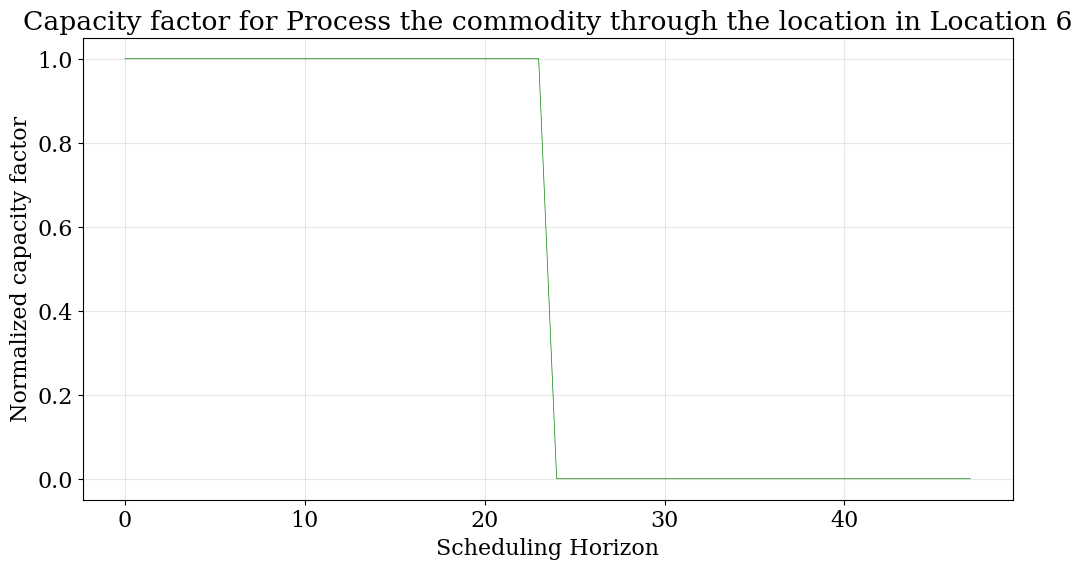

In [13]:
plot_scenario.capacity_factor(scenario=scenario, process=com1_process, location=loc6, color='green')

In [14]:
# problem_mincost.modes.pprint()

In [15]:
problem_mincost = formulate(scenario=scenario,
                            constraints={Constraints.COST, Constraints.TRANSPORT, Constraints.RESOURCE_BALANCE, Constraints.INVENTORY, Constraints.PRODUCTION, Constraints.DEMAND, Constraints.MODE},
                            demand_sign='eq', objective=Objective.COST_W_DEMAND_PENALTY)

constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint production mode
constraint inventory balance
constraint inventory network
constraint resource export
constraint transport export
constraint export
constraint transport capex
constraint transport network capex
constraint transport export network
constraint transport vopex
constraint transport network vopex
constraint transport fopex
constraint transport network fopex
constraint transport capacity UB no bin
constraint transport capacity LB no bin
constraint fixed nameplate min production mode
constraint fixed nameplate max production mode
constraint production mode wo binary
constraint production rate1
constraint production rate2
constraint production mode switch
constraint demand penalty
objective cost w demand penalty


In [16]:
results_mincost = solve(scenario=scenario, instance=problem_mincost, solver='gurobi', name='MILP')

Set parameter QCPDual to value 1
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 944961 rows, 2866470 columns and 1535807 nonzeros
Model fingerprint: 0xd5a230ed
Variable types: 2691540 continuous, 174930 integer (174930 binary)
Coefficient statistics:
  Matrix range     [6e-03, 5e+02]
  Objective range  [1e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 2e+02]
Found heuristic solution: objective 3622677.2360
Presolve removed 872623 rows and 2758278 columns
Presolve time: 0.23s
Presolved: 72338 rows, 108192 columns, 426727 nonzeros
Variable types: 50232 continuous, 57960 integer (57960 binary)
Deterministic concurrent LP optimizer: primal and dual simplex
Showing primal log only...
Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxati

In [17]:
sum(value for key, value in results_mincost.output['S'].items() if key[0] == 'loc5' and key[1] == 'com1_sold') /(daily_demand*_time_intervals*_exec_scenarios)

0.885680803571428

In [18]:
min(value for key, value in results_mincost.output['S'].items() if key[0] == 'loc5' and key[1] == 'com1_sold')

75.0

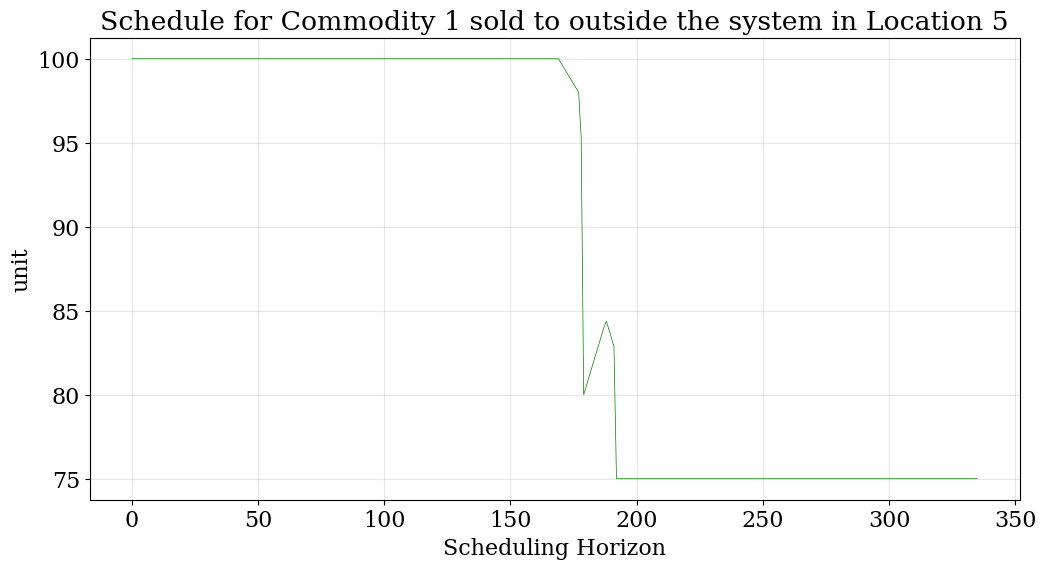

In [19]:
plot_results.schedule(results=results_mincost, y_axis='S', component='com1_sold', location='loc5', color='green')

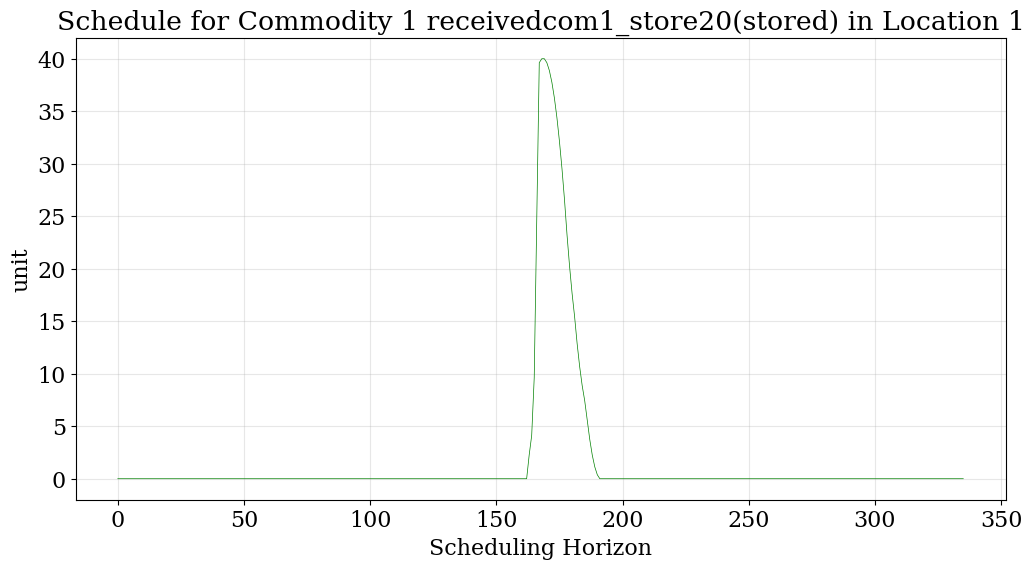

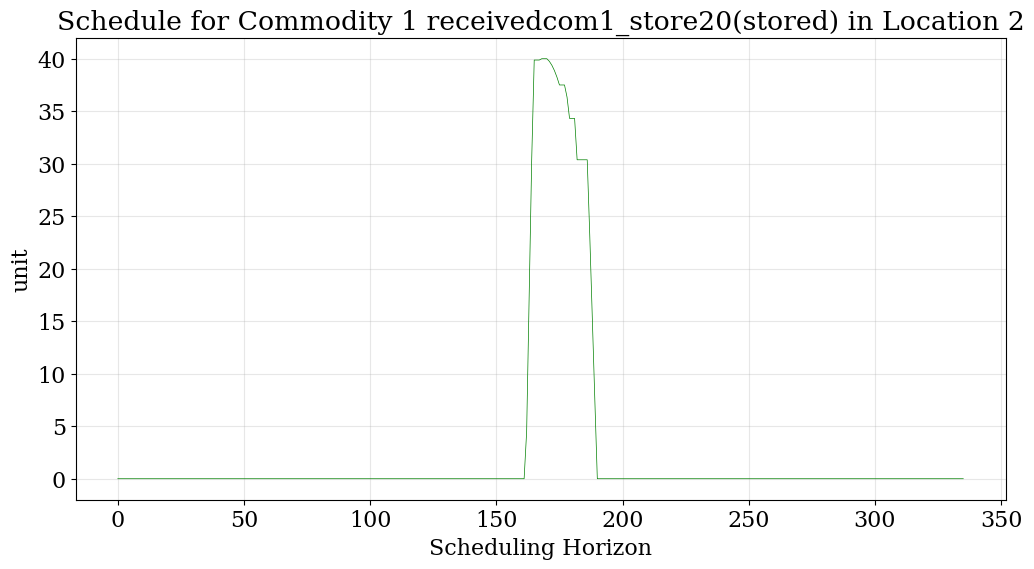

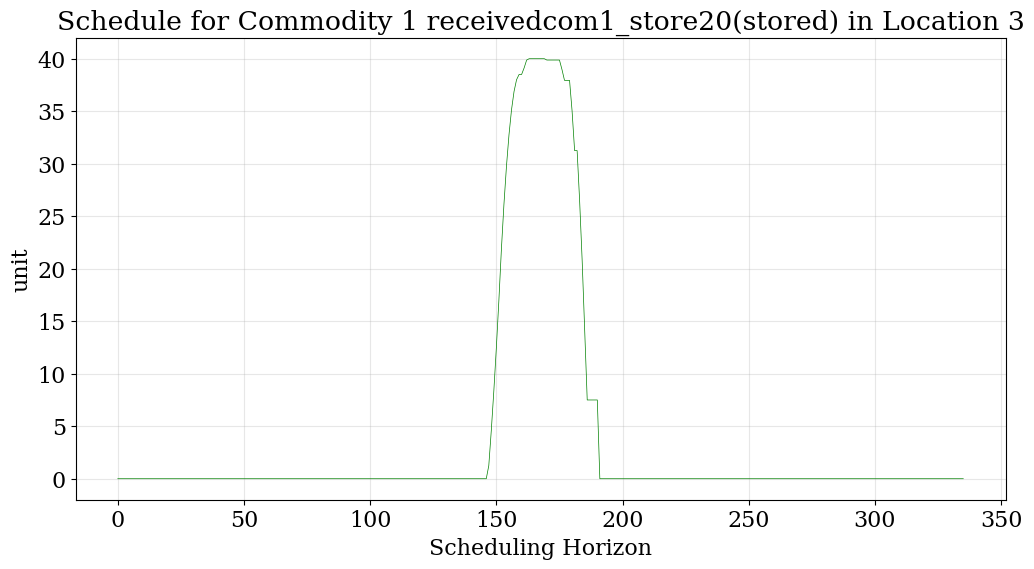

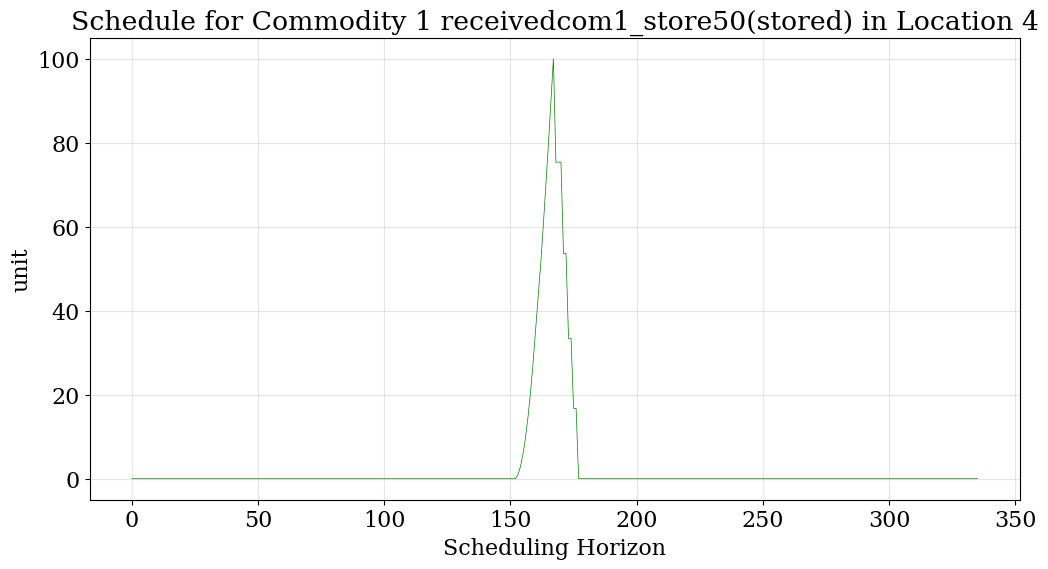

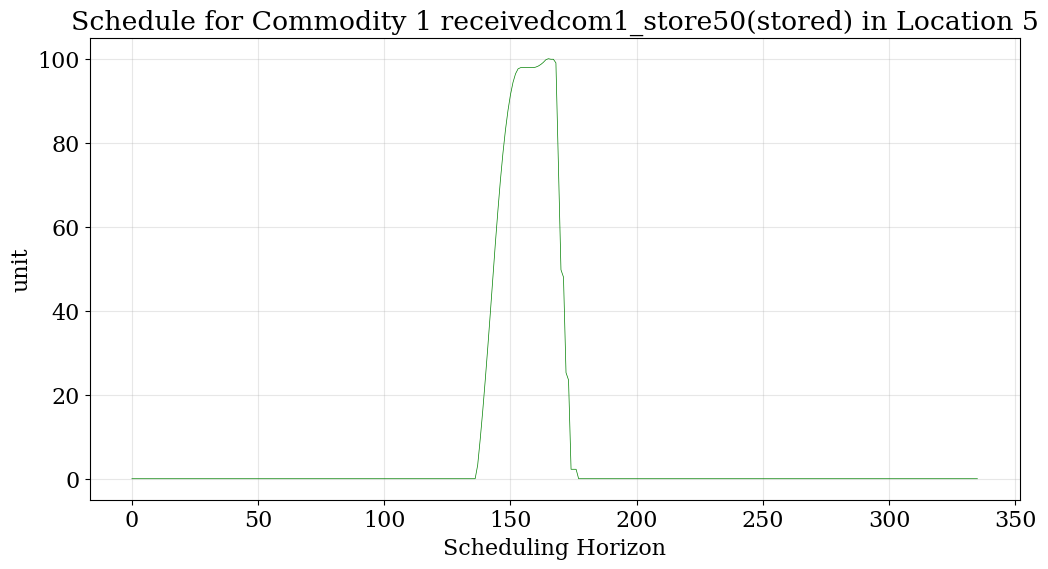

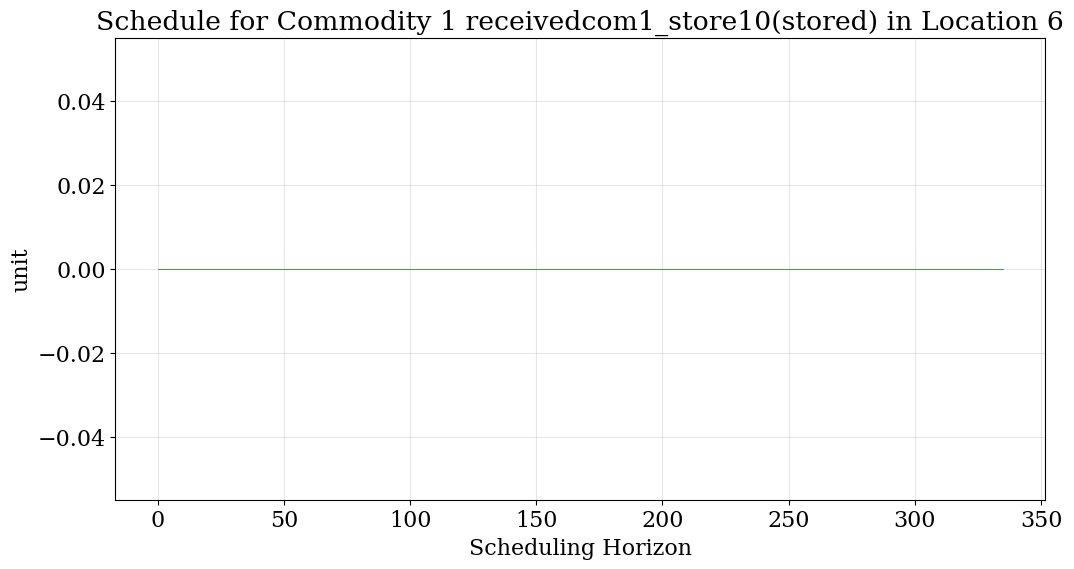

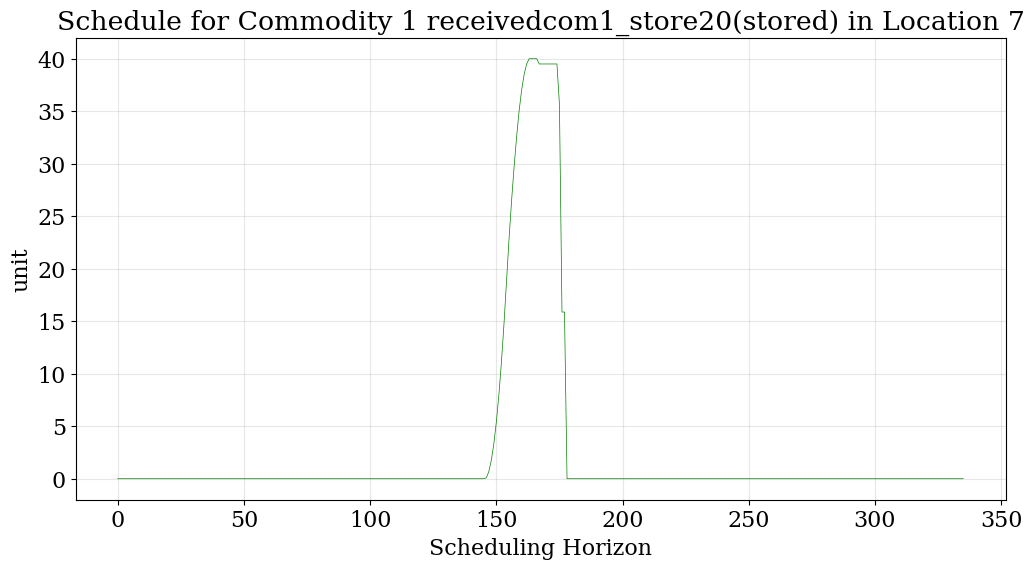

In [20]:
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_store20_com1_in_stored', location='loc1', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_store20_com1_in_stored', location='loc2', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_store20_com1_in_stored', location='loc3', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_store50_com1_in_stored', location='loc4', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_store50_com1_in_stored', location='loc5', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_store10_com1_in_stored', location='loc6', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_store20_com1_in_stored', location='loc7', color='green')

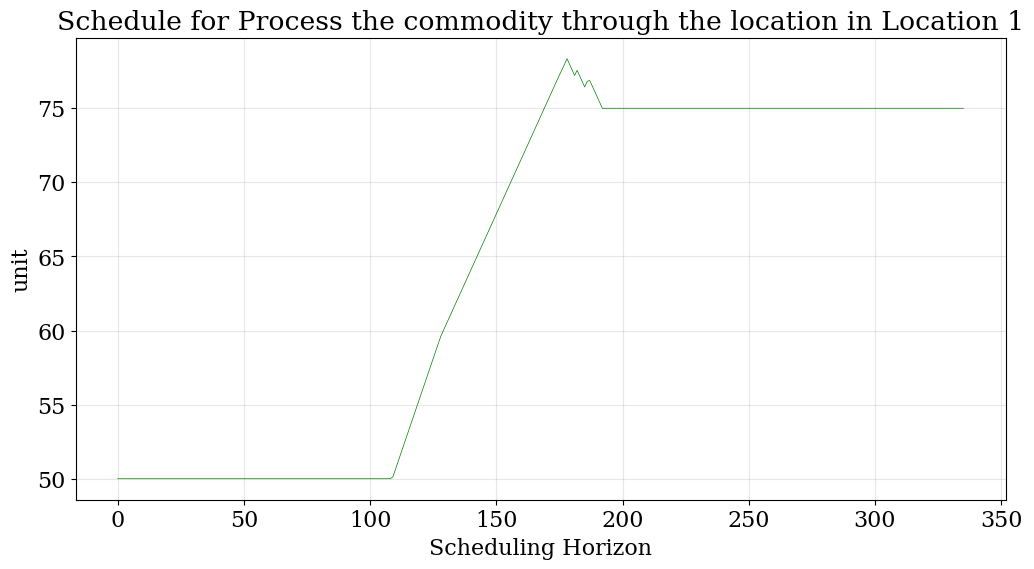

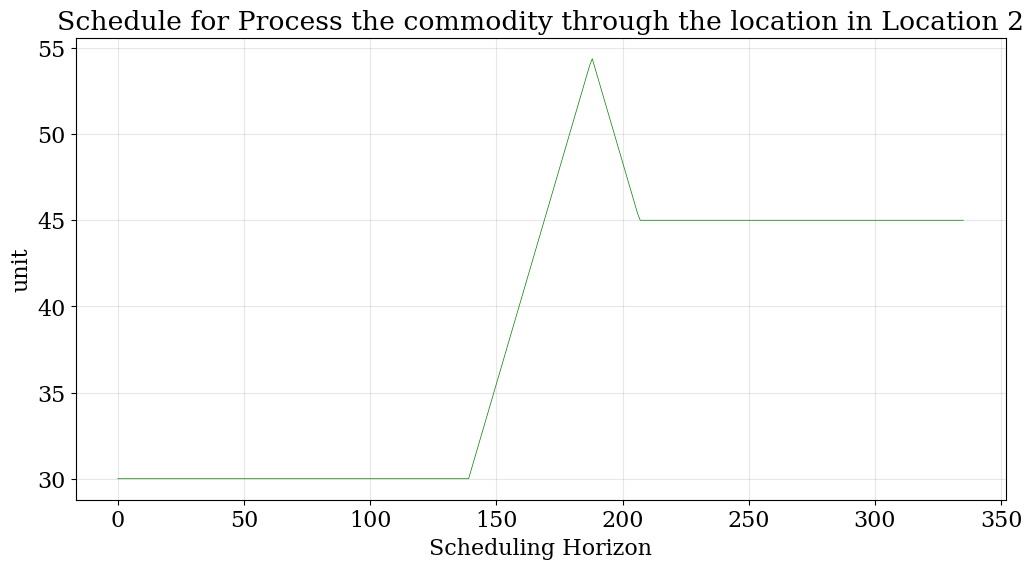

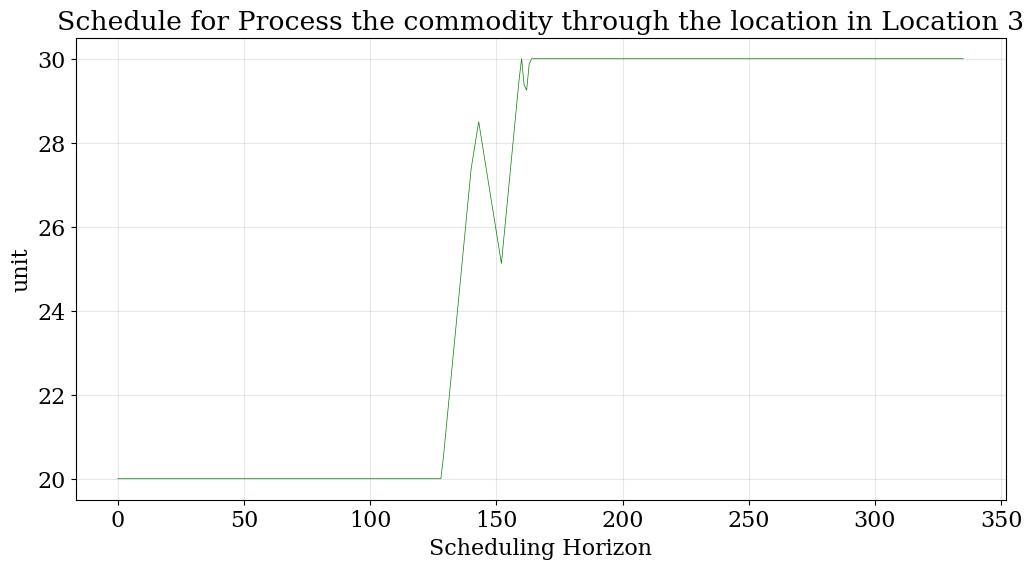

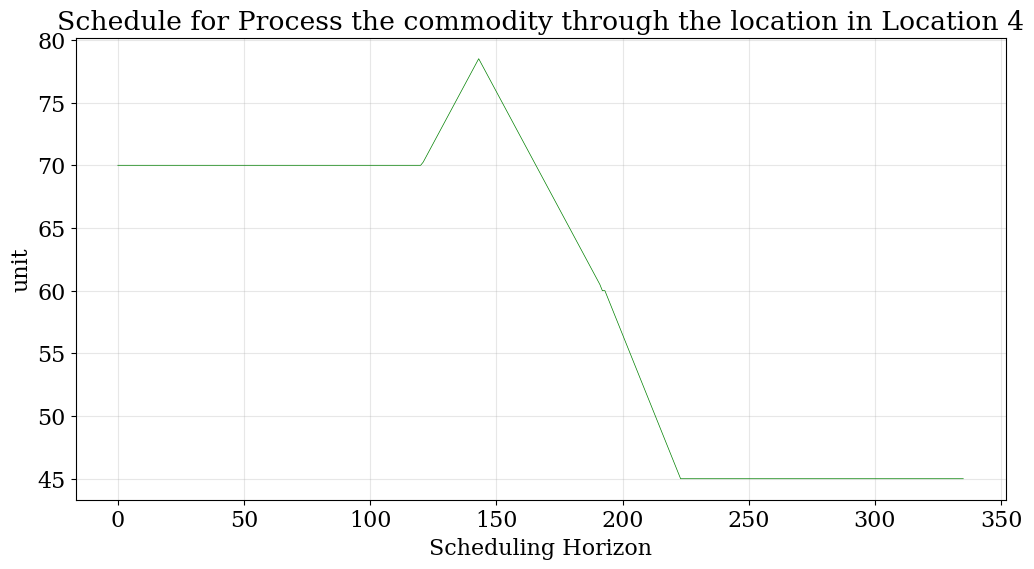

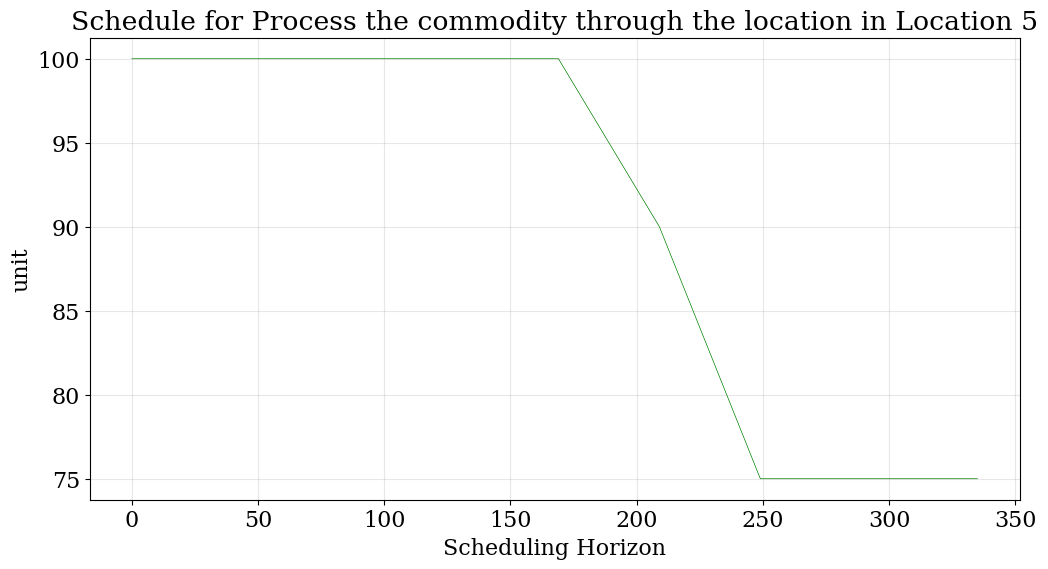

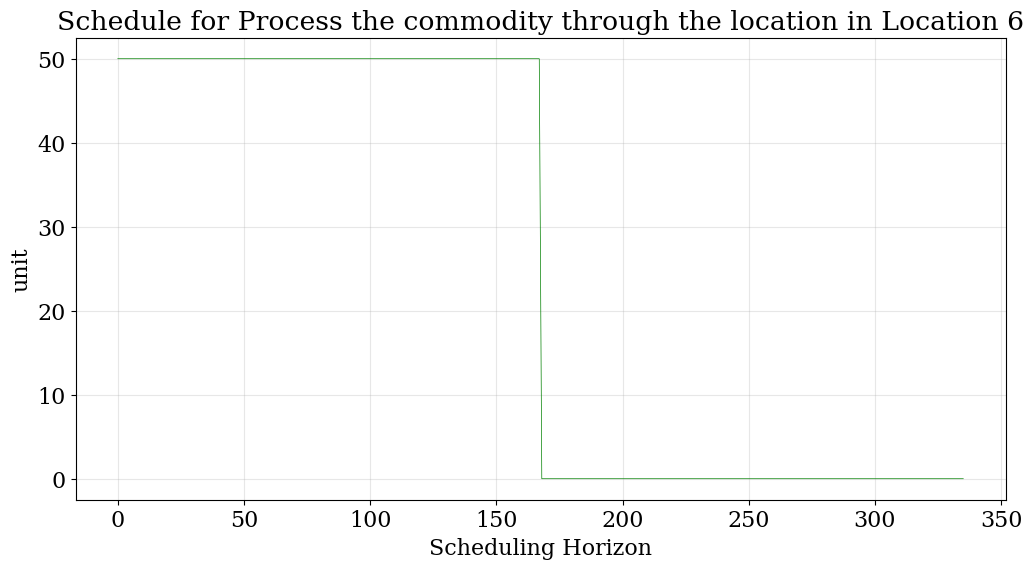

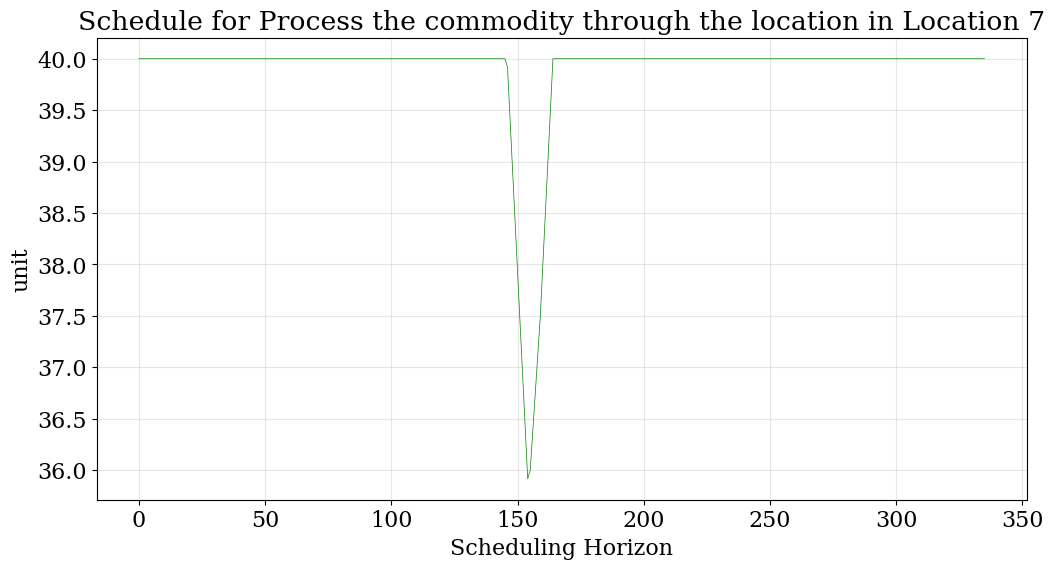

In [21]:
plot_results.schedule(results=results_mincost, y_axis='P', component='com1_process', location='loc1', color='green')
plot_results.schedule(results=results_mincost, y_axis='P', component='com1_process', location='loc2', color='green')
plot_results.schedule(results=results_mincost, y_axis='P', component='com1_process', location='loc3', color='green')
plot_results.schedule(results=results_mincost, y_axis='P', component='com1_process', location='loc4', color='green')
plot_results.schedule(results=results_mincost, y_axis='P', component='com1_process', location='loc5', color='green')
plot_results.schedule(results=results_mincost, y_axis='P', component='com1_process', location='loc6', color='green')
plot_results.schedule(results=results_mincost, y_axis='P', component='com1_process', location='loc7', color='green')

In [22]:
results_mincost.output['objective']

1031522.1297500012

In [23]:
demand_penalty*sum(value for key, value in results_mincost.output['Demand_penalty'].items()) + problem_mincost.Capex_network[0].value + problem_mincost.Vopex_network[0].value + problem_mincost.Capex_transport_network[0].value + problem_mincost.Vopex_transport_network[0].value + problem_mincost.Inv_cost_network[0].value

1031522.1297500014

In [24]:
demand_penalty*sum(value for key, value in results_mincost.output['Demand_penalty'].items()) + problem_mincost.Vopex_network[0].value + problem_mincost.Vopex_transport_network[0].value + problem_mincost.Inv_cost_network[0].value

768844.8937500012

In [25]:
demand_penalty*sum(value for key, value in results_mincost.output['Demand_penalty'].items())

384112.5000000011

In [26]:
problem_mincost.Capex_network.pprint()
problem_mincost.Fopex_network.pprint()
problem_mincost.Vopex_network.pprint()
problem_mincost.Capex_transport_network.pprint()
problem_mincost.Fopex_transport_network.pprint()
problem_mincost.Vopex_transport_network.pprint()
problem_mincost.Inv_cost_network.pprint()

Capex_network : Capex at network scale
    Size=1, Index=scales_network
    Key : Lower : Value    : Upper : Fixed : Stale : Domain
      0 :     0 : 237545.5 :  None : False : False : NonNegativeReals
Fopex_network : Fixed Opex at network scale
    Size=1, Index=scales_network
    Key : Lower : Value : Upper : Fixed : Stale : Domain
      0 :     0 :   0.0 :  None : False : False : NonNegativeReals
Vopex_network : Variable Opex at network scale
    Size=1, Index=scales_network
    Key : Lower : Value            : Upper : Fixed : Stale : Domain
      0 :     0 : 4759.32375000023 :  None : False : False : NonNegativeReals
Capex_transport_network : overall capex for transport at the network level
    Size=1, Index=scales_network
    Key : Lower : Value              : Upper : Fixed : Stale : Domain
      0 :     0 : 25131.735999999997 :  None : False : False : NonNegativeReals
Fopex_transport_network : overall fopex for transport at the network level
    Size=1, Index=scales_network
    K

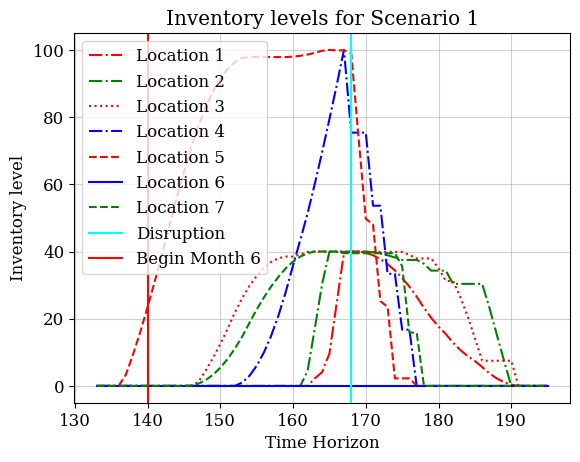

In [27]:
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)
fig, ax = plt.subplots()

# Plot data from the first dataset

key1 = 19
key2 = 27
start=key1*_time_intervals

ax.plot(range(start, len(list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc1' and key[1]=='com1_store20_com1_in_stored' and key[3]>=key1 and key[3]<=key2))+start), list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc1' and key[1]=='com1_store20_com1_in_stored' and key[3]>=key1 and key[3]<=key2), label='Location 1', color='red', linestyle='-.')

ax.plot(range(start, len(list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc2' and key[1]=='com1_store20_com1_in_stored'and key[3]>=key1 and key[3]<=key2))+start), list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc2' and key[1]=='com1_store20_com1_in_stored'and key[3]>=key1 and key[3]<=key2), label='Location 2', color='green', linestyle='-.')

ax.plot(range(start, len(list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc3' and key[1]=='com1_store20_com1_in_stored'and key[3]>=key1 and key[3]<=key2))+start), list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc3' and key[1]=='com1_store20_com1_in_stored'and key[3]>=key1 and key[3]<=key2), label='Location 3', color='red', linestyle=':')

ax.plot(range(start, len(list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc4' and key[1]=='com1_store50_com1_in_stored'and key[3]>=key1 and key[3]<=key2))+start), list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc4' and key[1]=='com1_store50_com1_in_stored'and key[3]>=key1 and key[3]<=key2), label='Location 4', color='blue', linestyle='-.')

ax.plot(range(start, len(list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc5' and key[1]=='com1_store50_com1_in_stored'and key[3]>=key1 and key[3]<=key2))+start), list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc5' and key[1]=='com1_store50_com1_in_stored'and key[3]>=key1 and key[3]<=key2), label='Location 5', color='red', linestyle='--')

ax.plot(range(start, len(list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc6' and key[1]=='com1_store10_com1_in_stored'and key[3]>=key1 and key[3]<=key2))+start), list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc6' and key[1]=='com1_store10_com1_in_stored'and key[3]>=key1 and key[3]<=key2), label='Location 6', color='blue', linestyle='-')

ax.plot(range(start, len(list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc7' and key[1]=='com1_store20_com1_in_stored'and key[3]>=key1 and key[3]<=key2))+start), list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc7' and key[1]=='com1_store20_com1_in_stored'and key[3]>=key1 and key[3]<=key2), label='Location 7', color='green', linestyle='--')

plt.axvline(x = 168, color = 'cyan', label = 'Disruption', linestyle = '-')
plt.axvline(x = 140, color = 'red', label = 'Begin Month 6', linestyle = '-')


# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Inventory level')
ax.set_title('Inventory levels for Scenario 1')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.6)
plt.rcdefaults()
# Show the plot
plt.show()

In [28]:
# problem_mincost.write('pyomo_model.lp', io_options={'symbolic_solver_labels': True})
# import gurobipy as GBP
# 
# gurobi_model = GBP.read('pyomo_model.lp')
# gurobi_model.computeIIS()
# gurobi_model.write('gurobi_model_iis.ilp')
# print('\nThe following constraints are in the IIS:')
# for c in gurobi_model.getConstrs():
#     if c.IISConstr: print(f'\t{c.constrname}: {gurobi_model.getRow(c)} {c.Sense} {c.RHS}')

In [29]:
key_ = 2

sum(value for key, value in results_mincost.output['P'].items() if key[3]<=key_ and key[1]!='com1_store10' and key[1]!='com1_store20' and key[1]!='com1_store50')*0.01 + \
sum(value for key, value in results_mincost.output['P'].items() if key[3]<=key_ and key[1]=='com1_store10')*scenario.vopex_dict['com1_store10'] + \
sum(value for key, value in results_mincost.output['P'].items() if key[3]<=key_ and key[1]=='com1_store20')*scenario.vopex_dict['com1_store20'] + \
sum(value for key, value in results_mincost.output['P'].items() if key[3]<=key_ and key[1]=='com1_store50')*scenario.vopex_dict['com1_store50'] + \
sum(value for key, value in results_mincost.output['Exp_F'].items() if key[0]=='loc1' and key[1]=='loc2' and key[4]<=key_ and value!=0 and value!=None)*scenario.distance_dict[('loc1','loc2')]*scenario.trans_vopex['truck12'] + \
sum(value for key, value in results_mincost.output['Exp_F'].items() if key[0]=='loc1' and key[1]=='loc3' and key[4]<=key_ and value!=0 and value!=None)*scenario.distance_dict[('loc1','loc3')]*scenario.trans_vopex['truck13'] + \
sum(value for key, value in results_mincost.output['Exp_F'].items() if key[0]=='loc2' and key[1]=='loc4' and key[4]<=key_ and value!=0 and value!=None)*scenario.distance_dict[('loc2','loc4')]*scenario.trans_vopex['truck24'] + \
sum(value for key, value in results_mincost.output['Exp_F'].items() if key[0]=='loc2' and key[1]=='loc5' and key[4]<=key_ and value!=0 and value!=None)*scenario.distance_dict[('loc2','loc5')]*scenario.trans_vopex['truck25'] + \
sum(value for key, value in results_mincost.output['Exp_F'].items() if key[0]=='loc3' and key[1]=='loc4' and key[4]<=key_ and value!=0 and value!=None)*scenario.distance_dict[('loc3','loc4')]*scenario.trans_vopex['truck34'] + \
sum(value for key, value in results_mincost.output['Exp_F'].items() if key[0]=='loc4' and key[1]=='loc5' and key[4]<=key_ and value!=0 and value!=None)*scenario.distance_dict[('loc4','loc5')]*scenario.trans_vopex['truck45'] + \
sum(value for key, value in results_mincost.output['Exp_F'].items() if key[0]=='loc4' and key[1]=='loc7' and key[4]<=key_ and value!=0 and value!=None)*scenario.distance_dict[('loc4','loc7')]*scenario.trans_vopex['truck47'] + \
sum(value for key, value in results_mincost.output['Exp_F'].items() if key[0]=='loc6' and key[1]=='loc4' and key[4]<=key_ and value!=0 and value!=None)*scenario.distance_dict[('loc6','loc4')]*scenario.trans_vopex['truck64'] + \
sum(value for key, value in results_mincost.output['Exp_F'].items() if key[0]=='loc7' and key[1]=='loc5' and key[4]<=key_ and value!=0 and value!=None)*scenario.distance_dict[('loc7','loc5')]*scenario.trans_vopex['truck75'] + \
sum(value for key, value in results_mincost.output['Inv'].items() if key[3]<=key_ and value!=0)*0.02 + \
sum(value for key, value in results_mincost.output['Demand_penalty'].items() if key[3]<=key_)*demand_penalty

26661.6

In [30]:
sum(value for key, value in results_mincost.output['P'].items() if key[3]<=key_ and key[1]!='com1_store10' and key[1]!='com1_store20' and key[1]!='com1_store50')*0.01 + \
sum(value for key, value in results_mincost.output['P'].items() if key[3]<=key_ and key[1]=='com1_store10')*scenario.vopex_dict['com1_store10'] + \
sum(value for key, value in results_mincost.output['P'].items() if key[3]<=key_ and key[1]=='com1_store20')*scenario.vopex_dict['com1_store20'] + \
sum(value for key, value in results_mincost.output['P'].items() if key[3]<=key_ and key[1]=='com1_store50')*scenario.vopex_dict['com1_store50']

226.8

In [31]:
sum(value for key, value in results_mincost.output['Inv'].items() if key[3]<=key_ and value!=0)*0.02

0.0

In [32]:
demand_penalty*sum(value for key, value in results_mincost.output['Demand_penalty'].items()) + problem_mincost.Vopex_network[0].value + problem_mincost.Vopex_transport_network[0].value + problem_mincost.Inv_cost_network[0].value

768844.8937500012

In [33]:
results_mincost.output['Inv']

{('loc1', 'com1_store10_com1_in_stored', 0, 0, 0): 0.0,
 ('loc1', 'com1_store10_com1_in_stored', 0, 0, 1): 0.0,
 ('loc1', 'com1_store10_com1_in_stored', 0, 0, 2): 0.0,
 ('loc1', 'com1_store10_com1_in_stored', 0, 0, 3): 0.0,
 ('loc1', 'com1_store10_com1_in_stored', 0, 0, 4): 0.0,
 ('loc1', 'com1_store10_com1_in_stored', 0, 0, 5): 0.0,
 ('loc1', 'com1_store10_com1_in_stored', 0, 0, 6): 0.0,
 ('loc1', 'com1_store10_com1_in_stored', 0, 1, 0): 0.0,
 ('loc1', 'com1_store10_com1_in_stored', 0, 1, 1): 0.0,
 ('loc1', 'com1_store10_com1_in_stored', 0, 1, 2): 0.0,
 ('loc1', 'com1_store10_com1_in_stored', 0, 1, 3): 0.0,
 ('loc1', 'com1_store10_com1_in_stored', 0, 1, 4): 0.0,
 ('loc1', 'com1_store10_com1_in_stored', 0, 1, 5): 0.0,
 ('loc1', 'com1_store10_com1_in_stored', 0, 1, 6): 0.0,
 ('loc1', 'com1_store10_com1_in_stored', 0, 2, 0): 0.0,
 ('loc1', 'com1_store10_com1_in_stored', 0, 2, 1): 0.0,
 ('loc1', 'com1_store10_com1_in_stored', 0, 2, 2): 0.0,
 ('loc1', 'com1_store10_com1_in_stored', 0, 2, 3

In [38]:
print(*[(key,value) for key, value in results_mincost.output['Inv'].items()], sep='\n')

(('loc1', 'com1_store10_com1_in_stored', 0, 0, 0), 0.0)
(('loc1', 'com1_store10_com1_in_stored', 0, 0, 1), 0.0)
(('loc1', 'com1_store10_com1_in_stored', 0, 0, 2), 0.0)
(('loc1', 'com1_store10_com1_in_stored', 0, 0, 3), 0.0)
(('loc1', 'com1_store10_com1_in_stored', 0, 0, 4), 0.0)
(('loc1', 'com1_store10_com1_in_stored', 0, 0, 5), 0.0)
(('loc1', 'com1_store10_com1_in_stored', 0, 0, 6), 0.0)
(('loc1', 'com1_store10_com1_in_stored', 0, 1, 0), 0.0)
(('loc1', 'com1_store10_com1_in_stored', 0, 1, 1), 0.0)
(('loc1', 'com1_store10_com1_in_stored', 0, 1, 2), 0.0)
(('loc1', 'com1_store10_com1_in_stored', 0, 1, 3), 0.0)
(('loc1', 'com1_store10_com1_in_stored', 0, 1, 4), 0.0)
(('loc1', 'com1_store10_com1_in_stored', 0, 1, 5), 0.0)
(('loc1', 'com1_store10_com1_in_stored', 0, 1, 6), 0.0)
(('loc1', 'com1_store10_com1_in_stored', 0, 2, 0), 0.0)
(('loc1', 'com1_store10_com1_in_stored', 0, 2, 1), 0.0)
(('loc1', 'com1_store10_com1_in_stored', 0, 2, 2), 0.0)
(('loc1', 'com1_store10_com1_in_stored', 0, 2, 3

In [40]:
loc1.storage_cost_dict

{'com1_store20_com1_in_stored': 0.02}

In [41]:
scenario.location_set

{loc1, loc2, loc3, loc4, loc5, loc6, loc7}

In [46]:
inv_zero = dict()
for loc in scenario.location_set:
    for res_stored in loc.storage_cost_dict:
        inv_zero[loc.name, res_stored, 0, 0, 6] = results_mincost.output['Inv'][loc.name,res_stored,0,0,6]

In [48]:
inv_zero

{('loc2', 'com1_store20_com1_in_stored', 0, 0, 6): 0.0,
 ('loc7', 'com1_store20_com1_in_stored', 0, 0, 6): 0.0,
 ('loc5', 'com1_store50_com1_in_stored', 0, 0, 6): 0.0,
 ('loc4', 'com1_store50_com1_in_stored', 0, 0, 6): 0.0,
 ('loc3', 'com1_store20_com1_in_stored', 0, 0, 6): 0.0,
 ('loc1', 'com1_store20_com1_in_stored', 0, 0, 6): 0.0,
 ('loc6', 'com1_store10_com1_in_stored', 0, 0, 6): 0.0}